# Определение наиболее выгодного региона нефтедобычи

Наша задача - помочь нефтедобывающей компании решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap*.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Обзор данных 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from numpy.random import RandomState

In [2]:
# Отключим предупреждение о цепном присваивании
pd.options.mode.chained_assignment = None

In [3]:
# Прочитаем все csv-файлы и выведем датасеты на экран
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

display(data_0.head())
display(data_1.head())
data_2.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Посмотрим информацию по датасетам

In [4]:
display(data_0.info())
display(data_1.info())
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В каждом датасете содержится 100000 записей. Структуры датасетов одинаковы, пропусков нет.

Признаки в датасете следующие:

* `id` — уникальный идентификатор скважины;
* `f0, f1, f2` — три признака точек (нам неизвестно, что они означают, но известно, что сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

### Предобработка 

#### Статистика по данным 

Взглянем на описательную статистику по датасетам.

In [5]:
display(data_0.describe())
display(data_1.describe())
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Во всех датасетах по всем признакам медианы и средние довольно близки. Считаем, что аномальных выбросов в данных нет.

#### Обработка дубликатов 

Посмотрим на количество уникальных записей признака `id`.

In [6]:
display(data_0.id.nunique())
display(data_1.id.nunique())
data_2.id.nunique()

99990

99996

99996

В датасетах присутствует от 4 до 10 дублированных значений в признаке `id`. Проверим датасеты на дубликаты.

In [7]:
display(data_0.duplicated().sum())
display(data_1.duplicated().sum())
data_2.duplicated().sum()

0

0

0

Все строки в датасетах уникальны. Посмотрим на дубликаты в признаке `id`.

In [8]:
data_0[data_0.id.duplicated(keep=False)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


In [9]:
data_1[data_1.id.duplicated(keep=False)]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [10]:
data_2[data_2.id.duplicated(keep=False)]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Наглядно видно, что несмотря на то, что у нас имеются дубликаты в признаке `id`, остальные признаки в дублированных объектах различаются. Возможно это связано с тем, что проводились повторные замеры в скважинах. Нам неизвестно, в хронологическом ли порядке находяться записи в датасетах. Максимальная доля дубликатов составляет 0,0001% от всех записей датасета. 

Удалим дубликаты, оставим только записи, которые расположены ниже в датасете. Предположим, что датасет заполнялся по порядку. Проверим результат.

In [11]:
data_0 = data_0.drop_duplicates(subset='id', keep='last').reset_index(drop=True)
data_1 = data_1.drop_duplicates(subset='id', keep='last').reset_index(drop=True)
data_2 = data_2.drop_duplicates(subset='id', keep='last').reset_index(drop=True)


display(data_0.id.duplicated().sum())
display(data_1.id.duplicated().sum())
data_2.id.duplicated().sum()

0

0

0

#### Удаление признаков

Удалим признак `id`, т.к. он не даст нашей модели какой-либо полезной информации. Идентификатор скважины - это случайный набор символов и он не поможет определить целевой признак.

In [12]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

display(data_0.columns)
display(data_1.columns)
data_2.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

## Обучение и проверка моделей

### Разделение датасетов на выборки

Разделим каждый датасет на учебную и валидационную выборки.

In [13]:
# Разделим датасет 0 на две выборки: учебную и валидационную в соотношении 0.75/0.25
target_0 = data_0['product']
features_0 = data_0.drop('product', axis=1)

features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=1)

#Проверим размер полученных выборок
display(features_0_train.shape)
features_0_valid.shape

(74992, 3)

(24998, 3)

In [14]:
# Разделим датасет 1 на две выборки: учебную и валидационную в соотношении 0.75/0.25
target_1 = data_1['product']
features_1 = data_1.drop('product', axis=1)

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=1)

#Проверим размер полученных выборок
display(features_1_train.shape)
features_1_valid.shape

(74997, 3)

(24999, 3)

In [15]:
# Разделим датасет 2 на две выборки: учебную и валидационную в соотношении 0.75/0.25
target_2 = data_2['product']
features_2 = data_2.drop('product', axis=1)

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=1)

#Проверим размер полученных выборок
display(features_2_train.shape)
features_2_valid.shape

(74997, 3)

(24999, 3)

### Масштабирование признаков

Отмасштабируем признаки для каждого датасета.

In [16]:
# Обозначим масштабируемые признаки
numeric = [
    'f0',
    'f1',
    'f2',
]

In [17]:
# Отмасштабируем признаки в датасете 0
scaler = StandardScaler()
scaler.fit(features_0_train[numeric])

features_0_train[numeric] = scaler.transform(features_0_train[numeric])
features_0_valid[numeric] = scaler.transform(features_0_valid[numeric])

# Выведем на экран отмасштабированную учебную выборку
features_0_train.head()

,f0,f1,f2
23482,-0.644986,1.694935,-0.240844
78499,-1.038627,1.529464,1.323512
41891,-0.418261,-0.894233,-1.338430
45458,-0.025129,0.936552,1.148631
63348,1.423971,-1.386338,-1.152141


In [18]:
# Отмасштабируем признаки в датасете 1
scaler = StandardScaler()
scaler.fit(features_1_train[numeric])

features_1_train[numeric] = scaler.transform(features_1_train[numeric])
features_1_valid[numeric] = scaler.transform(features_1_valid[numeric])

# Выведем на экран отмасштабированную учебную выборку
features_1_train.head()

,f0,f1,f2
77267,0.046374,-0.766176,-0.876494
64106,1.028877,0.242691,-1.461482
266,-1.047039,0.556037,-1.466914
23482,1.448002,0.259348,0.300477
97588,-1.475084,-0.801688,-0.871130


In [19]:
# Отмасштабируем признаки в датасете 2
scaler = StandardScaler()
scaler.fit(features_2_train[numeric])

features_2_train[numeric] = scaler.transform(features_2_train[numeric])
features_2_valid[numeric] = scaler.transform(features_2_valid[numeric])

# Выведем на экран отмасштабированную учебную выборку
features_2_train.head()

,f0,f1,f2
77267,-3.230092,-1.098621,0.024212
64106,1.735345,-1.464009,-1.421983
266,-0.460921,-0.815345,-1.414064
23482,0.985922,0.736131,-1.650855
97588,-0.302063,0.199724,-0.561447


### Обучение и проверка моделей

Обучим для каждого датасета свою модель линейной регрессии, сделаем предсказание и посчитаем корень из средней квадратичной ошибки (RMSE) для каждой модели. Выведем на экран RMSE, средний запас предсказанного сырья и средний истинный запас сырья.

In [20]:
model_0 = LinearRegression()
model_0.fit(features_0_train, target_0_train)
predictions_0 = model_0.predict(features_0_valid)
rmse_0_valid = mean_squared_error(target_0_valid, predictions_0, squared=False)

display(f'Значение RMSE модели №0: {round(rmse_0_valid, 4)}')
display(f'Предсказанный средний запас сырья: {round(predictions_0.mean(), 4)} тыс. баррелей')
f'Истинный средний запас сырья: {round(target_0_valid.mean(), 4)} тыс. баррелей'

'Значение RMSE модели №0: 37.8304'

'Предсказанный средний запас сырья: 92.5252 тыс. баррелей'

'Истинный средний запас сырья: 92.4565 тыс. баррелей'

In [21]:
model_1 = LinearRegression()
model_1.fit(features_1_train, target_1_train)
predictions_1 = model_1.predict(features_1_valid)
rmse_1_valid = mean_squared_error(target_1_valid, predictions_1, squared=False)

display(f'Значение RMSE модели №1: {round(rmse_1_valid, 4)}')
display(f'Предсказанный средний запас сырья: {round(predictions_1.mean(), 4)} тыс. баррелей')
f'Истинный средний запас сырья: {round(target_1_valid.mean(), 4)} тыс. баррелей'

'Значение RMSE модели №1: 0.8899'

'Предсказанный средний запас сырья: 69.0331 тыс. баррелей'

'Истинный средний запас сырья: 69.0376 тыс. баррелей'

In [22]:
model_2 = LinearRegression()
model_2.fit(features_2_train, target_2_train)
predictions_2 = model_2.predict(features_2_valid)
rmse_2_valid = mean_squared_error(target_2_valid, predictions_2, squared=False)

display(f'Значение RMSE модели №2: {round(rmse_2_valid, 4)}')
display(f'Предсказанный средний запас сырья: {round(predictions_2.mean(), 4)} тыс. баррелей')
f'Истинный средний запас сырья: {round(target_2_valid.mean(), 4)} тыс. баррелей'

'Значение RMSE модели №2: 39.843'

'Предсказанный средний запас сырья: 95.0644 тыс. баррелей'

'Истинный средний запас сырья: 94.8153 тыс. баррелей'

Оценка моделей:

Модели для регионов №0 и №2 показывают значение RMSE в диапазоне 37-39. В тоже время модель для региона №1 показала значение RMSE, равное 0,8899. Это очень выдающийся результат. Модель очень точно предсказывает объем сырья в скважинах. Корень из средней квадратичной ошибки составляет менее 1 тыс. баррелей. Т.е. наша модель ошибается в среднем, на 1 тыс. баррелей.

In [23]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182270,-0.001788,-0.030501
f1,0.182270,1.000000,-0.002610,-0.010168
f2,-0.001788,-0.002610,1.000000,0.999397
product,-0.030501,-0.010168,0.999397,1.000000


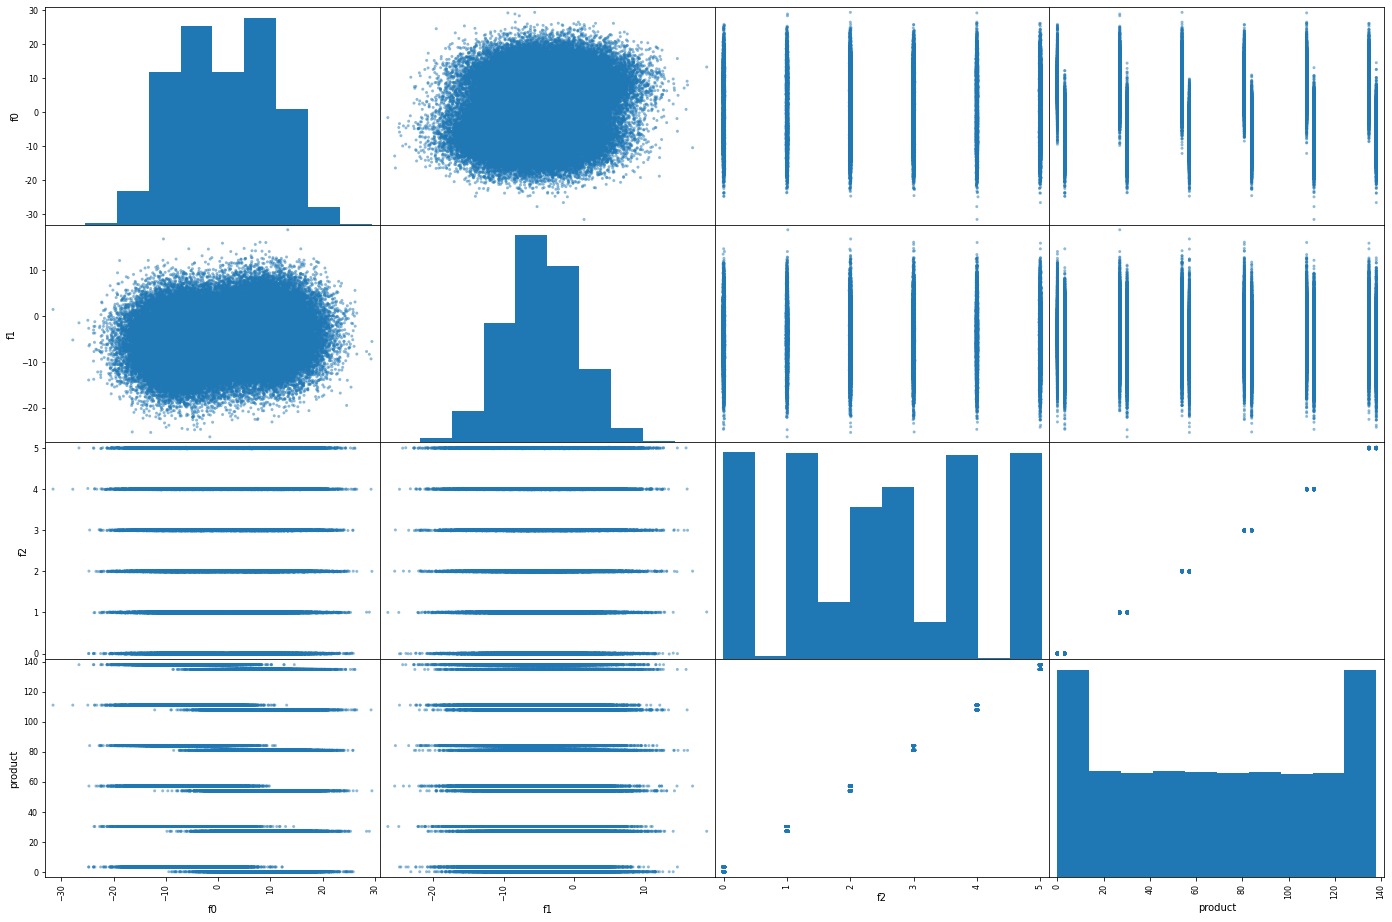

In [24]:
ax = pd.plotting.scatter_matrix(data_1, figsize=(24, 16))

## Подготовка к расчёту прибыли

### Создание переменных

Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [25]:
# Создадим переменные для условий задачи

NUMBER_OF_WELLS = 500        # Количество исследуемых скважин в регионе
NUMBER_OF_BEST_WELLS = 200   # Количество отбираемых лучших скважин в регионе
BUDGET = 10000000000         # Бюджет на разработку скважин в регионе, руб.
GROSS_PROFIT = 450000        # Доход или валовая прибыль с 1 тыс. баррелей, руб. 
THRESHOLD = 0.025            # Пороговое значение вероятности убытков
product = 0                  # Переменная для обозначения объёмов запасов в каждой скважине, тыс. баррелей

### Формулы для расчётов 

Составим формулу для расчёта минимально необходимого среднего количества продукта в месторождениях региона. Если среднее количество продукта в регионе выше или равно данному значению, то мы можем считать, что разработка данного региона будет, как минимум, безубыточна.

Будем считать, что условием для разработки региона является то, что валовая прибыль больше или равняется бюджету. То есть сумма продукта 200 лучших скважин, умноженная на валовую прибыль должна быть больше или равна бюджету. 

Запишем это формулой, где:
* `n = NUMBER_OF_BEST_WELLS`
* `p = product`
* `g = GROSS_PROFIT`

*Комментарий студента v.0: Я хотел попробовать записать формулу с помощью Latex. Не уверен, что правильно записал описанную выше формулу. Буду благодарен за любые комментарии)*

$$\sum_{i=p}^{n}i * g\geq budget$$

Минимальное среднее значение продукта (minimal mean product, MMP), в таком случае будет равно бюджету, деленному на произведение валовой прибыли и количества лучших скважин.

Запишем это формулой, где:
* `MMP` - это minimal mean product или минимальное среднее значение продукта
* `n = number_of_best_wells`
* `g = gross_profit`

$$MMP=\frac{budget}{(n*g)}$$

In [26]:
# Посчитаем MMP по описанной формуле
mmp = BUDGET / (NUMBER_OF_BEST_WELLS * GROSS_PROFIT)
f'Минимальное среднее количество продукта для разработки региона равно {round(mmp, 2)} тыс. баррелей'

'Минимальное среднее количество продукта для разработки региона равно 111.11 тыс. баррелей'

In [27]:
# Взглянем на средние значения продукта в регионах
display(data_0['product'].mean())
display(data_1['product'].mean())
data_2['product'].mean()

92.49948184460142

68.82523184270339

95.00042479767433

In [28]:
# Теперь взглянем средние значения 200 лучших скважин в регионах
display(data_0['product'].sort_values(ascending=False).head(200).mean())
display(data_1['product'].sort_values(ascending=False).head(200).mean())
data_2['product'].sort_values(ascending=False).head(200).mean()

184.83373964536008

137.9454077409057

189.55147698176646

Выводы:  
В результате расчётов получено значение минимального среднего количества продукта для разработки региона. Оно равно 111,11 тыс. баррелей. Это значение больше, чем средние значения продукта по регионам в целом. Но если мы отбираем 200 лучших скважин в каждом регионе, то средние значения продукта в данных скважинах ощутимо выше необходимого минимального среднего.

### Функция расчёта прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Наша функция на вход будет принимать датафрейм, в котором будут содержаться записи о 500 случайных скважинах региона. Среди записей будут содержаться данные о реальном объеме продукта в скважинах и об объеме продукта, который мы предскажем с помощью модели машинного обучения.

Ориентируясь на предсказания модели, мы возьмём 200 лучших скважин, посчитаем предполагаемую и реальную прибыль с этих скважин.

In [29]:
def calc_total_operating_profit(df, wells_number, gross_profit, operational_expenses):
    '''
    На вход функция принимает:
    df - датафрейм, который содержит как предсказанные объемы продукта в скважинах, так и реальные их значения
    wells_number - количество лучших скважин, которые будут взяты в разработку
    gross_profit - валовая прибыль с 1 тыс. баррелей
    operational_expenses - операционные расходы на разработку региона
    
    Функция возвращает величину операционной прибыли в рублях с округлением до двух знаков после запятой
    '''
    top_product_real = df.sort_values(by='predictions', ascending=False).head(wells_number)['product']
    top_product_predicted = df.sort_values(by='predictions', ascending=False).head(wells_number)['predictions']
    sum_of_real_product = top_product_real.sum()
    sum_of_predicted_product = top_product_predicted.sum()
    operating_profit_real = round((sum_of_real_product * gross_profit) - operational_expenses, 2)
    operating_profit_predicted = round((sum_of_predicted_product * gross_profit) - operational_expenses, 2)
    # display(top_product_real)
    # display(top_product_predicted)
    return operating_profit_real, operating_profit_predicted
    

## Расчёт прибыли и рисков 

### Подготовка 

Напишем функцию для расчёта средней прибыли, 95%-й доверительного интервала и вероятности убытков.

In [30]:
# Напишем функцию для расчёта средней прибыли, 95% доверительного интервала и вероятности убытков
def calc_bootstrap_profit(model, features, target, region_number, number_of_wells, state):
    '''
    Функция принимает на вход:
    model - обученная модель машинного обучения
    features - признаки интересующих нас скважин,
    target - целевой признак, объем продукта в скважинах
    region_number - номер региона,
    number_of_wells - количество скважин, которое мы отбираем для анализа,
    state - случайное состояние, сгенерированное функцией np.random.RandomState
    
    Функция возвращает результат в виде вывода на экран следующей информации:
    1. Разницу между предсказанной и реальной средней прибылью.
    2. Средняя реальная операционная прибыль региона.
    3. 95% доверительный интервал.
    4. Вероятность убытков
    '''
    
    df = pd.DataFrame(model.predict(features), columns=['predictions'])
    product = target.copy().reset_index(drop=True)
    df['product'] = product[df.index]
    
    values = []
    for i in range(1000):
        sample_df = df.sample(n=number_of_wells, replace=True, random_state=state)
        result = calc_total_operating_profit(sample_df, NUMBER_OF_BEST_WELLS, GROSS_PROFIT, BUDGET)
        values.append(result)

    df_values = pd.DataFrame(values, columns=['real', 'predicted'])
    mean_profit_diff = round(df_values.predicted.mean() - df_values.real.mean(), 2)
    higher_real = round(df_values.real.quantile(0.975), 2)
    lower_real = round(df_values.real.quantile(0.025), 2)
    loss_probability = round((df_values.real[df_values.real < 0].count() / df_values.shape[0]) * 100, 2)
    
    display(f'Средняя реальная операционная прибыль региона №{region_number}: {round(df_values.real.mean(), 2)} руб.')
    display(f'Предсказанная средняя прибыль - реальная средняя прибыль = {mean_profit_diff} руб.')
    display(f'95% доверительный интервал региона №{region_number} находится в диапазоне от {lower_real} до {higher_real} руб.')
    display(f'Вероятность убытков составляет {loss_probability}%')

### Расчёт прибыли и рисков 

In [31]:
target_0_valid.describe().T

count    24998.000000
mean        92.456470
std         44.378605
min          0.024830
25%         56.235889
50%         91.743137
75%        128.663201
max        185.362690
Name: product, dtype: float64

In [32]:
target_0_train.describe().T

count    74992.000000
mean        92.513820
std         44.259953
min          0.000000
25%         56.582051
50%         91.875377
75%        128.538843
max        185.364347
Name: product, dtype: float64

In [33]:
# Применим нашу функцию к каждому региону по отдельности
state = np.random.RandomState(42)

display('-------------------------------------------------')
calc_bootstrap_profit(model_0, features_0_valid, target_0_valid, 0, NUMBER_OF_WELLS, state)
display('-------------------------------------------------')
calc_bootstrap_profit(model_1, features_1_valid, target_1_valid, 1, NUMBER_OF_WELLS, state)
display('-------------------------------------------------')
calc_bootstrap_profit(model_2, features_2_valid, target_2_valid, 2, NUMBER_OF_WELLS, state)
display('-------------------------------------------------')

'-------------------------------------------------'

'Средняя реальная операционная прибыль региона №0: 397627626.9 руб.'

'Предсказанная средняя прибыль - реальная средняя прибыль = -42539687.79 руб.'

'95% доверительный интервал региона №0 находится в диапазоне от -127587661.64 до 883764803.54 руб.'

'Вероятность убытков составляет 6.6%'

'-------------------------------------------------'

'Средняя реальная операционная прибыль региона №1: 478125300.16 руб.'

'Предсказанная средняя прибыль - реальная средняя прибыль = -2448111.37 руб.'

'95% доверительный интервал региона №1 находится в диапазоне от 77305967.75 до 885796503.98 руб.'

'Вероятность убытков составляет 1.1%'

'-------------------------------------------------'

'Средняя реальная операционная прибыль региона №2: 337596703.2 руб.'

'Предсказанная средняя прибыль - реальная средняя прибыль = -56309666.6 руб.'

'95% доверительный интервал региона №2 находится в диапазоне от -174401722.13 до 887907891.17 руб.'

'Вероятность убытков составляет 10.4%'

'-------------------------------------------------'

In [34]:
#код ревьюера
sample_features = features_0_valid.sample(n= NUMBER_OF_WELLS, replace=True, random_state=state)
sample_df = sample_features.merge(target_0_valid, left_index=True, right_index=True)
sample_df['predictions'] = model_0.predict(sample_features)
top_product_pred = sample_df.sort_values(by='predictions', ascending=False)
top_product_real = top_product_pred.head(NUMBER_OF_BEST_WELLS)['product']
sum_of_real_product = top_product_real.sum()
operating_profit_real = round((sum_of_real_product *  GROSS_PROFIT) - BUDGET, 2)

In [35]:
sample_features.index

Int64Index([98946, 56788, 19609, 38800,  3073, 91152, 21958, 53746, 76974,
            77879,
            ...
            65482, 75244,  8243, 99943, 52903, 97677, 15510, 74028, 16804,
            39163],
           dtype='int64', length=500)

In [36]:
sample_df.index

Int64Index([  171,   317,   548,   557,   840,   897,   900,  1274,  1749,
             1833,
            ...
            98447, 98946, 98957, 99118, 99286, 99429, 99623, 99647, 99764,
            99943],
           dtype='int64', length=500)

### Выводы 

В результате применения линейной регрессии в качестве модели машинного обучения и техники Bootstrap с генерацией 1000 выборок для каждого региона, были получены следующие данные:

Для региона №0:
1. Реальная средняя операционная прибыль региона №0: 398 млн. руб.
2. Реальная прибыль больше предсказанной на 43 млн. руб.
2. 95% доверительный интервал региона №0 находится в диапазоне от -128 до 884 млн. руб.
3. Вероятность убытков составляет 6.6%.

Для региона №1:
1. Реальная средняя операционная прибыль региона №1: 478 млн. руб.
2. Реальная прибыль больше предсказанной на 2 млн. руб.
2. 95% доверительный интервал региона №1 находится в диапазоне от 77 до 885 млн. руб.
3. Вероятность убытков составляет 1.1%.

Для региона №2:
1. Реальная средняя операционная прибыль региона №1: 337 млн. руб.
2. Реальная прибыль больше предсказанной на 56 млн. руб.
2. 95% доверительный интервал региона №1 находится в диапазоне от -174 до 888 млн. руб.
3. Вероятность убытков составляет 10.4%.

Наименее выгодным регионом является регион №2 с реальной средней прибылью в 337 млн. руб. и вероятностью убытков в 10.4%.

Наиболее выгодным регионом для разработки является регион №1 с реальной средней операционной прибылью в размере 478 млн. руб. Вероятность убытков для данного региона составляет 1.1%, что меньше установленного порога в 2.5%. 

Для разработки рекомендован регион №1.